# Text Scrapping Assignment
Precipitation is a major driver for non-point source pollutants runoff, and the impact of precipitation may vary annually, seasonally, or even monthly. For example, soil is more prone to erosion during planting seasons (March-May) when land cover is minimal. Consequently, a similar precipitation events (intensity and duration) may result in greater soil erosion during planting season as compared to the late-growing season. <br>

Therefore, it is important to understand the precipitation pattern when evaluating the fate and transport of non-point source pollutants. The objectives of this task are: <br>
1) To gather historical precipitation data through an open API <br>
2) Plot daily precipitation depth for each monitoring year (2016-2018) <br>
3) Calculate and plot monthly cumulative precipitation depth <br>
4) Calculate and plot annual cumulative precipitation depth <br>
5) Compare the precipitation depths between the monitoring years

In the future development, this data will be paired with nutrient concentration and loading data to identify any possible correlations.


In [1]:
import urllib
import urllib.parse
import json
import pandas as pd
import numpy as np
import datetime as dt
import calendar
from datetime import datetime
import pprint

pd.set_option('mode.chained_assignment', None)

## Objective 1
To gather historical precipitation data through an open API <br> 

In[2] and [3] provided by https://github.com/ekapope/WorldWeatherOnline/tree/master/wwo_hist

In [2]:
def extract_monthly_data(data):
    num_days = len(data)
    # initialize df_month to store return data
    df_month = pd.DataFrame()
    for i in range(num_days):
        # extract this day
        d = data[i]
        # astronomy data is the same for the whole day
        astr_df = pd.DataFrame(d['astronomy'])
        # hourly data; temperature for each hour of the day
        hourly_df = pd.DataFrame(d['hourly'])
        # this wanted_key will be duplicated and use 'ffill' to fill up the NAs
        wanted_keys = ['date', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex'] # The keys you want
        subset_d = dict((k, d[k]) for k in wanted_keys if k in d)
        this_df = pd.DataFrame(subset_d,index=[0])        
        df = pd.concat([this_df.reset_index(drop=True), astr_df], axis=1)
        # concat selected astonomy columns with hourly data
        df = pd.concat([df,hourly_df], axis=1)
        df = df.fillna(method='ffill')
        # make date_time columm to proper format
        # fill leading zero for hours to 4 digits (0000-2400 hr)
        df['time'] = df['time'].apply(lambda x: x.zfill(4))
        # keep only first 2 digit (00-24 hr) 
        df['time'] = df['time'].str[:2]
        # convert to pandas datetime
        df['date_time'] = pd.to_datetime(df['date'] + ' ' + df['time'])
        # keep only interested columns
        col_to_keep = ['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex', 
               'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset', 
               'DewPointC',  'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph',
               'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
               'winddirDegree', 'windspeedKmph']
        df = df[col_to_keep]
        df_month = pd.concat([df_month,df])
    return(df_month)

In [3]:
#function to retrive data by date range and location
#default frequency = 1 hr
#each month costs 1 request (free trial 500 requests/key, as of 30-May-2019)
def retrieve_this_location(api_key,location,start_date,end_date,frequency):
    
    start_time = datetime.now()
    
    # create list of months, convert to month begins (first day of each month)
    list_mon_begin= pd.date_range(start_date,end_date, freq='1M')-pd.offsets.MonthBegin(1)
    # convert to Series and append first day of the last month
    list_mon_begin = pd.concat([pd.Series(list_mon_begin), pd.Series(pd.to_datetime(end_date,infer_datetime_format=True).replace(day=1))], ignore_index=True)
    # change the begin date to start_date
    list_mon_begin[0] = pd.to_datetime(start_date,infer_datetime_format=True)
    
    # create list of months, convert to month ends (last day of each month)
    list_mon_end = pd.date_range(start_date,end_date, freq='1M')-pd.offsets.MonthEnd(0)
    # convert to Series and append the end_date
    list_mon_end = pd.concat([pd.Series(list_mon_end), pd.Series(pd.to_datetime(end_date,infer_datetime_format=True))], ignore_index=True)
    
    # count number of months to be retrieved
    total_months = len(list_mon_begin)

    # initialize df_hist to store return data
    df_hist = pd.DataFrame()
    for m in range(total_months):
        
        start_d =str(list_mon_begin[m])[:10]
        end_d =str(list_mon_end[m])[:10]
        print('Currently retrieving data for '+location+': from '+start_d+' to '+end_d)
        
        url_page = 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key='+api_key+'&q='+location+'&format=json&date='+start_d+'&enddate='+end_d+'&tp='+str(frequency)
        json_page = urllib.request.urlopen(url_page)
        json_data = json.loads(json_page.read().decode())
        data= json_data['data']['weather']
       # call function to extract json object
        df_this_month = extract_monthly_data(data)
        df_hist = pd.concat([df_hist,df_this_month])
        
        time_elapsed = datetime.now() - start_time
        print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))
    return(df_hist)

In [4]:
# retrieving data for dates provided by user

API_key = '3bbd19dc238c4542a08213223192409'
location = '42.2422,-95.0381'
startdate = input('Enter start date as YYYY-MM-DD')
enddate = input('Enter end date as YYYY-MM-DD')
startdate = datetime.strptime(startdate, '%Y-%m-%d')
enddate = datetime.strptime(enddate, '%Y-%m-%d')
weather_data  = retrieve_this_location(API_key, location, startdate, enddate,'default')

Enter start date as YYYY-MM-DD2016-01-01
Enter end date as YYYY-MM-DD2018-12-31
Currently retrieving data for 42.2422,-95.0381: from 2016-01-01 to 2016-01-31
Time elapsed (hh:mm:ss.ms) 0:00:01.411494
Currently retrieving data for 42.2422,-95.0381: from 2016-02-01 to 2016-02-29
Time elapsed (hh:mm:ss.ms) 0:00:02.801734
Currently retrieving data for 42.2422,-95.0381: from 2016-03-01 to 2016-03-31
Time elapsed (hh:mm:ss.ms) 0:00:04.079026
Currently retrieving data for 42.2422,-95.0381: from 2016-04-01 to 2016-04-30
Time elapsed (hh:mm:ss.ms) 0:00:05.242391
Currently retrieving data for 42.2422,-95.0381: from 2016-05-01 to 2016-05-31
Time elapsed (hh:mm:ss.ms) 0:00:06.579416
Currently retrieving data for 42.2422,-95.0381: from 2016-06-01 to 2016-06-30
Time elapsed (hh:mm:ss.ms) 0:00:07.939809
Currently retrieving data for 42.2422,-95.0381: from 2016-07-01 to 2016-07-31
Time elapsed (hh:mm:ss.ms) 0:00:09.155186
Currently retrieving data for 42.2422,-95.0381: from 2016-08-01 to 2016-08-31
Ti

In [5]:
weather_data.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2016-01-01 00:00:00,-2,-9,0.0,8.7,1,0,50,12:36 AM,12:53 PM,...,-16,34,98,93,0.0,1030,-8,10,288,22
1,2016-01-01 03:00:00,-2,-9,0.0,8.7,1,0,50,12:36 AM,12:53 PM,...,-16,40,92,94,0.0,1029,-8,10,286,27
2,2016-01-01 06:00:00,-2,-9,0.0,8.7,1,0,50,12:36 AM,12:53 PM,...,-18,51,23,90,0.0,1028,-9,10,272,29
3,2016-01-01 09:00:00,-2,-9,0.0,8.7,1,2,50,12:36 AM,12:53 PM,...,-15,56,8,81,0.0,1026,-6,10,268,30
4,2016-01-01 12:00:00,-2,-9,0.0,8.7,1,2,50,12:36 AM,12:53 PM,...,-9,41,16,79,0.0,1024,-2,10,246,26


In [6]:
ppt =  weather_data [['date_time','precipMM','tempC']]
ppt.head()

,date_time,precipMM,tempC
0,2016-01-01 00:00:00,0.0,-8
1,2016-01-01 03:00:00,0.0,-8
2,2016-01-01 06:00:00,0.0,-9
3,2016-01-01 09:00:00,0.0,-6
4,2016-01-01 12:00:00,0.0,-2


In [7]:
# separate date and time so that daily average can be calculated using "groupby"
ppt['Date']= ppt['date_time'].dt.date

In [8]:
print(ppt.head())
print(ppt.dtypes)

            date_time precipMM tempC        Date
0 2016-01-01 00:00:00      0.0    -8  2016-01-01
1 2016-01-01 03:00:00      0.0    -8  2016-01-01
2 2016-01-01 06:00:00      0.0    -9  2016-01-01
3 2016-01-01 09:00:00      0.0    -6  2016-01-01
4 2016-01-01 12:00:00      0.0    -2  2016-01-01
date_time    datetime64[ns]
precipMM             object
tempC                object
Date                 object
dtype: object


In [9]:
# converting precip and temperature values from object to string then to interger/float
ppt['Date'] = pd.to_datetime(ppt['Date'])
ppt['precipMM'] = ppt['precipMM'].astype(float)
ppt['tempC'] = ppt['tempC'].astype(str).astype(int)

In [10]:
# calculate daily cumulative precip and average temp
daily_ppt = ppt.groupby('Date').agg({'precipMM':'sum', 'tempC':'mean'})
print(daily_ppt.head())
print(daily_ppt.dtypes)

            precipMM   tempC
Date                        
2016-01-01       0.0  -5.750
2016-01-02       0.0  -6.000
2016-01-03       0.1  -6.625
2016-01-04       0.1 -10.125
2016-01-05       0.0  -4.875
precipMM    float64
tempC       float64
dtype: object


In [11]:
# exporting daily ppt file as csv 

export_ppt = daily_ppt.to_csv('BHL_weather_data.csv', index=True)

In [12]:
# convert Date index into column

daily_ppt.reset_index(level=0, inplace=True)
daily_ppt ['year'] = pd.DatetimeIndex(daily_ppt['Date']).year
daily_ppt ['month'] = pd.DatetimeIndex(daily_ppt['Date']).month

daily_ppt.tail()

,Date,precipMM,tempC,year,month
1091,2018-12-27,5.6,3.750,2018,12
1092,2018-12-28,0.4,-8.500,2018,12
1093,2018-12-29,0.0,-11.375,2018,12
1094,2018-12-30,0.0,-2.750,2018,12
1095,2018-12-31,0.2,-3.000,2018,12


## Objective 2
Plot daily precipitation depth for each monitoring year (2016-2018)

In [13]:
# split the dataset based on year
gbl = globals()

startyear = startdate.year
endyear = enddate.year
years = list(range(startyear, endyear+1))

for curr_year in years:
    year_name = str(curr_year)
    gbl['ppt_'+year_name] = daily_ppt[daily_ppt['year'] == curr_year]
    # the dataframe for each year can be called using 'ppt_YYYY'           

In [14]:
# test calling 2018 dataframe using 'ppt_YYYY'

ppt_2018.head()

,Date,precipMM,tempC,year,month
731,2018-01-01,0.0,-27.000,2018,1
732,2018-01-02,0.0,-18.000,2018,1
733,2018-01-03,0.0,-16.375,2018,1
734,2018-01-04,0.1,-18.500,2018,1
735,2018-01-05,0.0,-17.875,2018,1


In [17]:
# example code from Adina on how to create a list with two-part name e.g. "ppt_" + "YYYY"
# Adina suggested to use nested loop i.e. a loop to create a variable list, then another loop to process the data

# example colde to create variable list
index_base = "check"
variable_list = []
for x in range(0, 10):
    new_name = index_base + '_' + str(x)
    variable_list.append(new_name)
print(variable_list)

# example code to process data
#counter = 0
#assignment_var = variable_list[counter]
#counter = counter + 1 

['check_0', 'check_1', 'check_2', 'check_3', 'check_4', 'check_5', 'check_6', 'check_7', 'check_8', 'check_9']


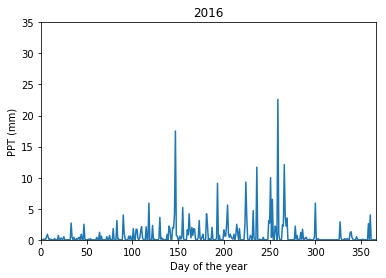

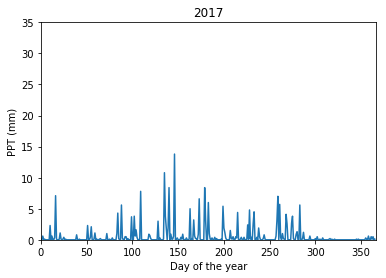

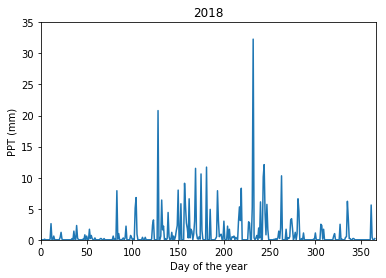

In [19]:
import matplotlib.pyplot as plt

# extract day of year from Date, then plot time series daily ppt
monitoring_years = (ppt_2016, ppt_2017, ppt_2018) # same comment as above, would like to automate this naming
startyear = startdate.year

for df in (monitoring_years):
    df['Day_of_year'] = df['Date'].dt.dayofyear
    plt.plot(df['Day_of_year'], df['precipMM'])
    plt.title(startyear)
    plt.xlabel('Day of the year')
    plt.ylabel('PPT (mm)')
    plt.axis([0, 366, 0, 35])
    plt.show()
    startyear = startyear + 1

## Objective 3
Calculate and plot monthly cumulative precipitation depth

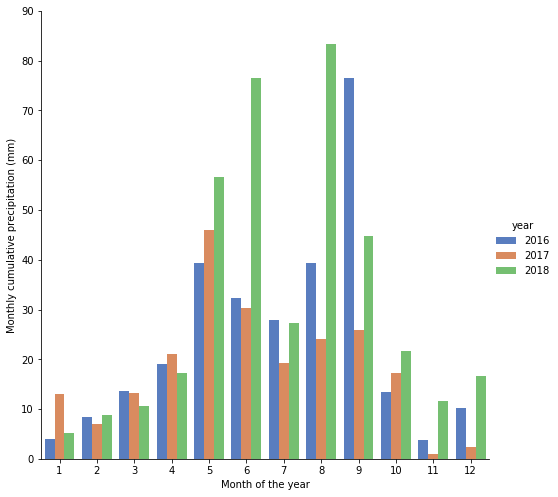

In [20]:
import seaborn as sns

monthly_precip = pd.DataFrame(daily_ppt.groupby(['year','month']).sum()['precipMM'])
monthly_precip.reset_index(inplace=True)
monthly_plot = sns.catplot(x="month", y="precipMM", hue="year", data=monthly_precip, height=7, kind="bar", palette="muted")
plt.ylim(0,90)
plt.xlabel('Month of the year')
plt.ylabel('Monthly cumulative precipitation (mm)')
plt.show()

## Objective 4
Calculate and plot annual cumulative precipitation depth

In [21]:
# calculating cumulative precip
monitoring_years = (ppt_2016, ppt_2017, ppt_2018) 
# Ideally, I want to use the loop to replace the script (manually inserted dataframe names) above but I couldn't get it to work 
# It should look something like 'ppt_'& YYYY (i.e. calling dataframes with two parts name fixedname+numericalname)

for df in (monitoring_years):
    df['cum_precipMM'] = df['precipMM'].cumsum()

In [22]:
print(ppt_2016.tail())
print(ppt_2017.tail())
print(ppt_2018.tail())

          Date  precipMM  tempC  year  month  Day_of_year  cum_precipMM
361 2016-12-27       0.0 -2.000  2016     12          362         287.6
362 2016-12-28       0.0  1.375  2016     12          363         287.6
363 2016-12-29       0.0 -0.250  2016     12          364         287.6
364 2016-12-30       0.0  0.250  2016     12          365         287.6
365 2016-12-31       0.0 -1.625  2016     12          366         287.6
          Date  precipMM   tempC  year  month  Day_of_year  cum_precipMM
726 2017-12-27       0.5 -18.250  2017     12          361         219.4
727 2017-12-28       0.1 -13.000  2017     12          362         219.5
728 2017-12-29       0.5 -13.750  2017     12          363         220.0
729 2017-12-30       0.0 -21.125  2017     12          364         220.0
730 2017-12-31       0.1 -25.500  2017     12          365         220.1
           Date  precipMM   tempC  year  month  Day_of_year  cum_precipMM
1091 2018-12-27       5.6   3.750  2018     12          

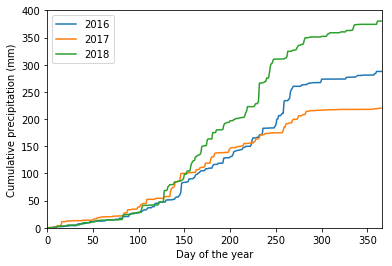

In [23]:
# cumulative precip plot
startyear = startdate.year

for df in (monitoring_years):
    plt.plot(df['Day_of_year'], df['cum_precipMM'], label = startyear)
    startyear = startyear +1

plt.rcParams["figure.figsize"] = (10,8) 
plt.legend()
plt.axis([0, 366, 0, 400])
plt.xlabel('Day of the year')
plt.ylabel('Cumulative precipitation (mm)')
plt.show()    

## Objective 5
Compare the precipitation depths between the monitoring years

Discussion: <br>
1) The time-series daily precipitation plots showed the precipitation pattern and distribution throughout the year. The precipitation pattern (especially the largest storms) can be compared with nutrient data to determine if storm events increased the nutrient export concentrations and loads. An alternative way to present the plots is to use "month" on the x-axis instead of "day of the year". <br>
2) In relative to other months of the year, May through September received the highest amount of precipitation except for July. The nutrient export pattern also may depends on the timing of fertilizer application and crop planting, where April to May are likely to experience greater runoff from precipitation events. <br>
3) 2018 received the highest precipitation depth, and followed by 2016 and 2017. <br>